This notebook demonstrates a PDOT simulation where **all** maze walls translate over time. The resulting density snapshots are saved in `examples/figures/moving_all_walls_density_snapshots.png`.

/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


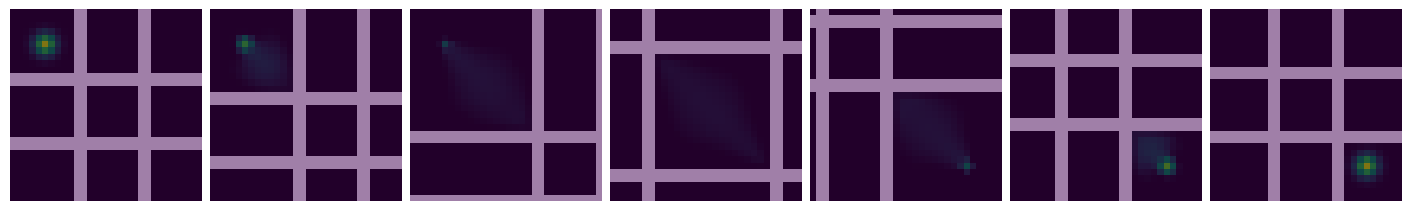

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.dynamicUOT import computeGeodesic

T = 30
grid_size = 30

def make_frame(t):
    frame = np.zeros((grid_size, grid_size))
    # vertical walls moving right
    for x0 in [10, 20]:
        x = (x0 + t) % grid_size
        frame[:, x:x+2] = 1.0
    # horizontal walls moving down
    for y0 in [10, 20]:
        y = (y0 + t) % grid_size
        frame[y:y+2, :] = 1.0
    return frame

H = np.stack([make_frame(t) for t in range(T)], axis=0)
F = np.zeros((T,))

indices = np.arange(grid_size)/grid_size
xx, yy = np.meshgrid(indices, indices)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1), mean=[5./grid_size,5./grid_size], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx,yy],axis=-1), mean=[24./grid_size,24./grid_size], cov=2./36**2)

ll = (1.0,1.0,1.0)
x,_ = computeGeodesic(rho_0, rho_1, T, ll, H, F, p=2.0, q=2.0, delta=10.0, niter=1000, big_matrix=True)

snap_fracs=[0.0,0.1,0.3,0.5,0.7,0.9,1.0]
idx=[int(round(f*T)) for f in snap_fracs]
H_add=np.concatenate([H,H[-1].reshape(1,*H.shape[1:])],0)
densities=[rho_0]+[x.V.D[0][k] for k in idx[1:-1]]+[rho_1]
obstacles=[H_add[k]>0 for k in idx]
vmin=min(d.min() for d in densities)
vmax=max(d.max() for d in densities)
fig,axes=plt.subplots(1,len(snap_fracs),figsize=(14,3),constrained_layout=True)
for ax,d,o in zip(axes,densities,obstacles):
    ax.imshow(d, cmap='viridis', vmin=vmin, vmax=vmax, origin='upper')
    ax.imshow(o, cmap='Greys_r', alpha=0.5, origin='upper')
    ax.axis('off')
fig.savefig('figures/moving_all_walls_density_snapshots.png', dpi=300, bbox_inches='tight')
plt.show()
